# Actor determination method 3.1: Based on operation dates
This notebook depicts the third methodology for actor determination as described in the corresponding master thesis. Known operations are used as a measure to determine active threat actors. The actors will be sorted based on the number of operations. An alternative method is implemented in [Method 3.2](./Method%203_2.ipynb), where new actors are weighed more heavily. 
A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls. 

This notebook includes code for experiments on TTP subset sizes to be used in control prioritization. 

![Diagram representation of method 1](./docs/images/Method3.png)

## 1. Determine relevant threats  and actors
### 1.1. Read ETDA and MITRE data

<AxesSubplot:title={'center':'Operations over the years'}>

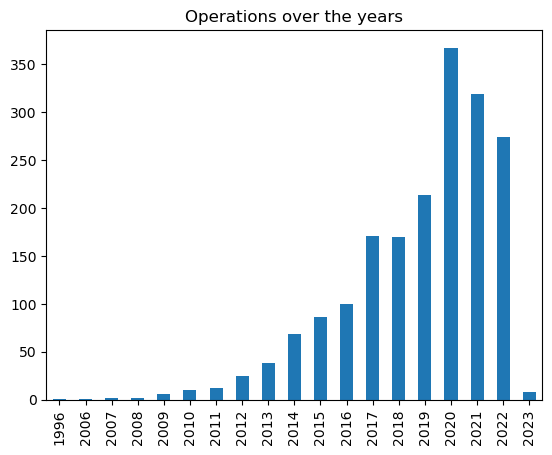

In [63]:
import datetime
import pandas as pd

SECTOR = 'Government'

YEAR = datetime.date.today().year
YEAR = 2021
INTERVAL = 0
TTP_THRESHOLD = 0

import pandas as pd

merge_df = pd.read_json('data/ETDA_ATTCK_merge.json',encoding='utf-8')
# df = pd.DataFrame(merge_list)
merge_df['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations over the years")


#### 1.2. Preprocessing

In [64]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

agg_dict = {}
for column in merge_df.columns:
    if column == 'mitre_attack_ttps':
        agg_dict[column] = 'sum'
    else:
        agg_dict[column] = 'first'

merge_df = merge_df.groupby(['etda_name']).agg(agg_dict)
merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

C:\Users\a.winters\AppData\Local\Temp\ipykernel_19324\773326629.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())


#### 1.3. Filter on sector

<AxesSubplot:title={'center':'Operations within Government sector over the years'}>

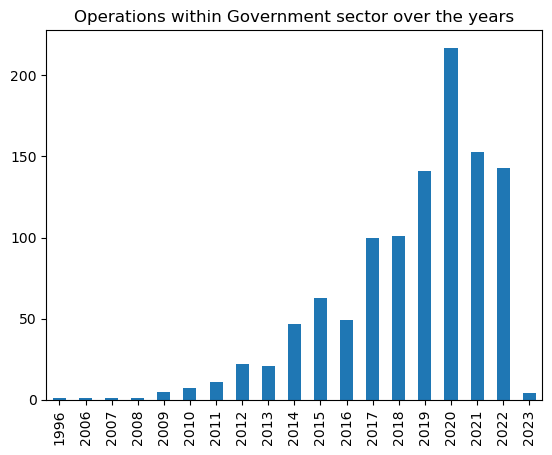

In [65]:
def filter_by_sector(df, sector):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] == sector]

actors_filtered = filter_by_sector(merge_df, SECTOR)
actors_filtered['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations within {} sector over the years".format(SECTOR))

#### Observation
How is the date derived? Date of reported breach, or date of actual breach.

Are reports relevant? 

#### 1.4. Count number of recent operations
Remove actors with no operations

<AxesSubplot:title={'center':'Top 5 actors targeting Government sector.\nBased on operations between 2021 and 2021'}, ylabel='Actor'>

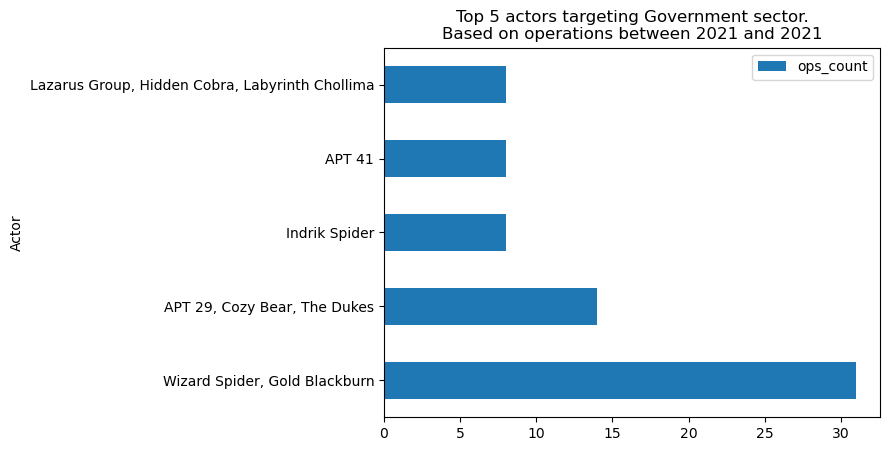

In [66]:
def filter_by_operation_year(df, interval):
    years = list(range((YEAR-interval),YEAR+1))
    years = [str(i) for i in years]
    df['etda_operation_year'] = df['etda_operation_year'].apply(lambda x: [i for i in x if i in years])
    return df

actors_filtered = filter_by_operation_year(actors_filtered, INTERVAL)    
actors_filtered['ops_count'] = actors_filtered['etda_operation_year'].apply(len)
actors_filtered = actors_filtered.loc[actors_filtered['ops_count']>0].sort_values(by='ops_count',ascending=False)
actors_filtered.nlargest(5,'ops_count').plot(kind='barh',x='etda_name',xlabel='Actor',ylabel='Number of registered operations',title="Top 5 actors targeting {} sector.\nBased on operations between {} and {}".format(SECTOR,YEAR-INTERVAL,YEAR))

<AxesSubplot:title={'center':'Distribution of actor operations from actors targeting Government sector.\nOperations between 2021 and 2021'}, ylabel='Frequency'>

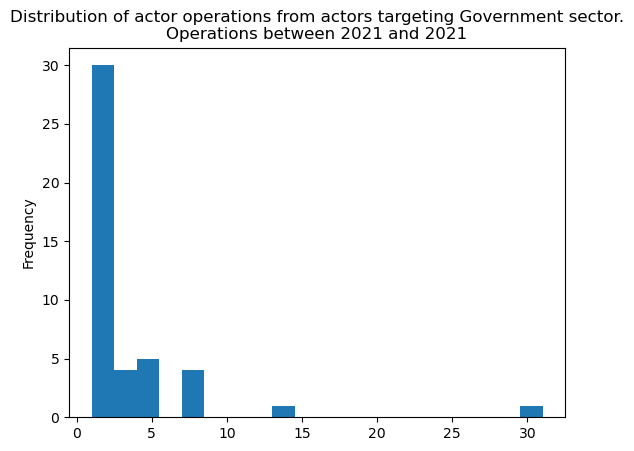

In [67]:
actors_filtered['ops_count'].plot(kind='hist',bins=20,x='etda_name',xlabel='Actor',ylabel='Number of registered operations',title="Distribution of actor operations from actors targeting {} sector.\nOperations between {} and {}".format(SECTOR,YEAR-INTERVAL,YEAR))

## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort
TODO: Define weight calculation

In [68]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

actors_filtered['actor_weight'] = normalize(actors_filtered['ops_count'])

actors_filtered.sort_values(by='actor_weight',ascending=False)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
unique_ttps = to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

print('Number of actors:',actors_ranked.index.size)
print('Number of TTPs:\t', unique_ttps.index.size)

Number of actors: 45
Number of TTPs:	 307


<AxesSubplot:title={'center':'Top 5 actors targeting Government sector based on operations between 2021 and 2021 (normalized)'}, ylabel='Actor Name'>

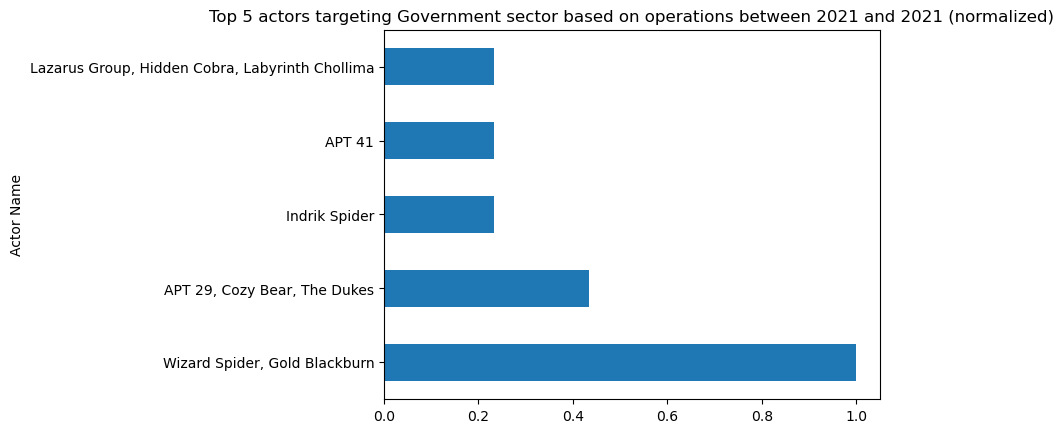

In [69]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',xlabel='Actor Name', title="Top 5 actors targeting {} sector based on operations between {} and {} (normalized)".format(SECTOR,YEAR-INTERVAL,YEAR))

In [70]:
actors_ranked

,actor_weight,mitre_attack_ttps
etda_name,,
"Wizard Spider, Gold Blackburn",1.000000,"[T1070.004, T1557.001, T1543.003, T1003.002, T..."
"APT 29, Cozy Bear, The Dukes",0.433333,"[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Indrik Spider,0.233333,"[T1486, T1003.001, T1059.001, T1204.002, T1059..."
APT 41,0.233333,"[T1203, T1574.002, T1078, T1104, T1005, T1016,..."
"Lazarus Group, Hidden Cobra, Labyrinth Chollima",0.233333,"[T1573.001, T1070.003, T1588.002, T1560.002, T..."
Doppel Spider,0.200000,[Not Available]
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",0.133333,"[T1059.007, T1057, T1087.002, T1555, T1105, T1..."
"Reaper, APT 37, Ricochet Chollima, ScarCruft",0.133333,"[T1055, T1053.005, T1189, T1559.002, T1566.001..."
"Magic Hound, APT 35, Cobalt Illusion, Charming Kitten",0.133333,"[T1105, T1053.005, T1059.001, T1586.002, T1564..."


#### Observations
Since the Government sector is the most represented in the ETDA dataset, this one is chosen for the tests. 13 of the actors from the reports target this sector. APT 29 is mentioned the most across reports. This is due to their notorious SolarWinds attack in 2020, which is mentioned often. In 2021 they also launched a big spear-phishing campaign. This actor is followed by Wizard Spider, a ransomware actor that is very active.

It is mainly these two actors that exceed the others in terms of how often they are mentioned. The other mentioned actors have a weigth just below 1.0.

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [71]:
actors_ranked['number_of_actors'] = 1
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

C:\Users\a.winters\AppData\Local\Temp\ipykernel_19324\823944124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_ranked['number_of_actors'] = 1


#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [72]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
print(ttps_ranked.sort_values(by='actor_weight',ascending=False))

                   actor_weight  number_of_actors
mitre_attack_ttps                                
T1059.003              3.000000                21
T1059.001              2.933333                21
T1027                  2.933333                24
T1204.002              2.866667                24
T1547.001              2.833333                20
...                         ...               ...
T1036.002              0.000000                 2
T1558.001              0.000000                 1
T1137.004              0.000000                 1
T1572                  0.000000                 1
T1573.002              0.000000                 1

[307 rows x 2 columns]


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [73]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','kill_chain_phases','id','tactic','technique_detection','impact_type']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"

[taxii2client.v20] [WARNING ] [2023-05-23 13:00:01,345] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-05-23 13:00:01,370] TAXII Server Response with different amount of objects! Setting per_request=750


#### 2.3.4. Calculate weights

In [74]:
ttps_enriched['ttp_weight'] = normalize(ttps_enriched['actor_weight'])
ttps_enriched = ttps_enriched.drop(['actor_weight'],axis=1)

#### Statistics

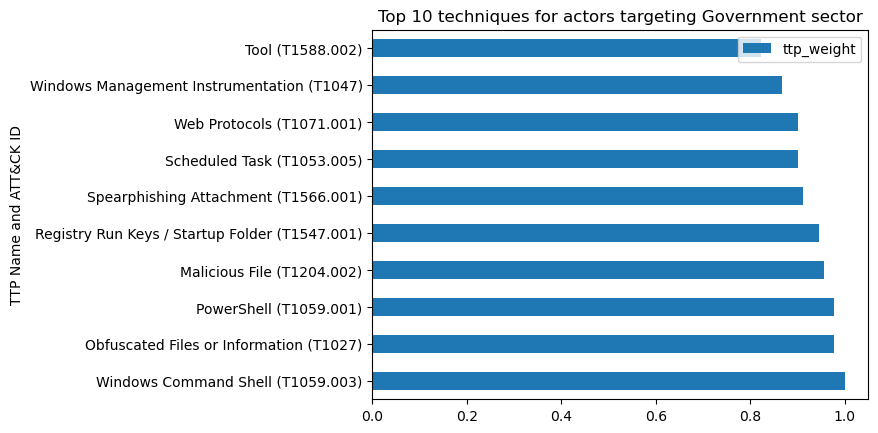

In [75]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',xlabel="TTP Name and ATT&CK ID" ,title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

# ttps_enriched.plot.hist(column="number_of_actors",bins=10, title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
ttps_enriched = ttps_enriched.drop(['number_of_actors'],axis=1)

Only take the top percentage of the TTPs

In [76]:
PERCENTAGE = 1

def take_percentage(percentage,df):
    top_percent = int(len(df) * PERCENTAGE)
    print("Taking {}%; {} entries".format(percentage*100,top_percent))
    return df.nlargest(top_percent,columns="ttp_weight")

def take_threshold(threshold, df):
    return df.loc[df['ttp_weight']>threshold]


ttps_enriched = take_percentage(PERCENTAGE,ttps_enriched)
# ttps_enriched = take_threshold(TTP_THRESHOLD,ttps_enriched)

Taking 100%; 307 entries


#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool]'(https://attack.mitre.org/techniques/T1588/002/), is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [77]:
# Load ATT&CK to NIST 800-53 mapping
def get_nist_attck_mapping():
    nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings.xlsx")
    nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)
    return nist_attck_mapping

def get_cis_attck_mapping():
    return None

def get_iso_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2022_ATTCKv82.xlsx")
    return iso_attck_mapping

Merge the TTPs with the controls. Only keep the TTPs that have a weight above a certain threshold. This threshold will be experimented with. The following values are considered:
- All TTPs
- threshold > 0.25
- threshold > 0.5
- threshold > 0.7
- threshold > 0.9

In [78]:
ttp_control_map = get_iso_attck_mapping()

ttp_control_merge = ttp_control_map.merge(ttps_enriched, left_on="Technique ID", right_on="technique_id",how="inner")
ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
print("Number of TTPS:",ttp_control_merge['Technique ID'].value_counts().index.size)
print("Number of controls:",ttp_control_merge['Control ID'].value_counts().index.size)
ttp_control_merge

Number of TTPS: 195
Number of controls: 42


,Control ID,Technique ID,Control Name,technique_id,technique,kill_chain_phases,id,tactic,technique_detection,impact_type,technique_name_id,ttp_weight
1134,8.70,T1059.003,Protection against malware,T1059.003,Windows Command Shell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--d1fcf083-a721-4223-aedf-bf8960...,[execution],Usage of the Windows command shell may be comm...,NaN,Windows Command Shell (T1059.003),1.000000
1135,8.19,T1059.003,Installation of software on operational systems,T1059.003,Windows Command Shell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--d1fcf083-a721-4223-aedf-bf8960...,[execution],Usage of the Windows command shell may be comm...,NaN,Windows Command Shell (T1059.003),1.000000
513,8.80,T1059.001,Management of technical vulnerabilities,T1059.001,PowerShell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--970a3432-3237-47ad-bcca-7d8cbb...,[execution],"If proper execution policy is set, adversaries...",NaN,PowerShell (T1059.001),0.977778
526,5.30,T1059.001,Segregation of duties,T1059.001,PowerShell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--970a3432-3237-47ad-bcca-7d8cbb...,[execution],"If proper execution policy is set, adversaries...",NaN,PowerShell (T1059.001),0.977778
519,8.40,T1059.001,Access to source code,T1059.001,PowerShell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--970a3432-3237-47ad-bcca-7d8cbb...,[execution],"If proper execution policy is set, adversaries...",NaN,PowerShell (T1059.001),0.977778
...,...,...,...,...,...,...,...,...,...,...,...,...
802,8.20,T1558.001,Privileged access rights,T1558.001,Golden Ticket,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--768dce68-8d0d-477a-b01d-0eea98...,[credential-access],"Monitor for anomalous Kerberos activity, such ...",NaN,Golden Ticket (T1558.001),0.000000
801,8.50,T1558.001,Secure authentication,T1558.001,Golden Ticket,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--768dce68-8d0d-477a-b01d-0eea98...,[credential-access],"Monitor for anomalous Kerberos activity, such ...",NaN,Golden Ticket (T1558.001),0.000000
800,8.90,T1558.001,Configuration management,T1558.001,Golden Ticket,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--768dce68-8d0d-477a-b01d-0eea98...,[credential-access],"Monitor for anomalous Kerberos activity, such ...",NaN,Golden Ticket (T1558.001),0.000000
799,8.30,T1558.001,Information access restriction,T1558.001,Golden Ticket,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--768dce68-8d0d-477a-b01d-0eea98...,[credential-access],"Monitor for anomalous Kerberos activity, such ...",NaN,Golden Ticket (T1558.001),0.000000


Get TTPs incl number of controls that mitigate them

<AxesSubplot:title={'center':'Distribution of TTP weights for actors targeting Government sector'}, ylabel='Frequency'>

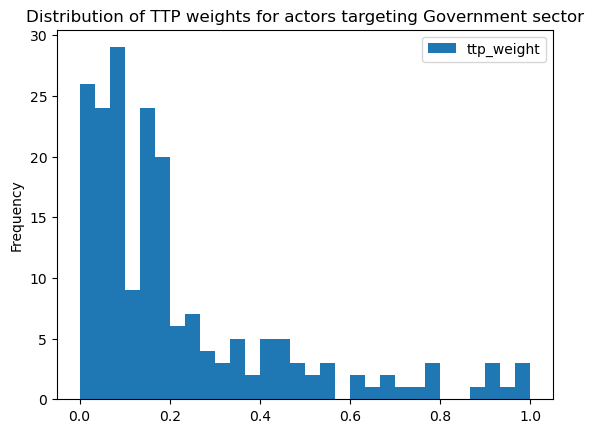

In [79]:
ttp_control_merge[['Technique ID','ttp_weight']].drop_duplicates().plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
# ttp_control_merge['ttp_weight'].plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR),xlabel="TTP weights")

**Observations**

The TTP weights are a normalised summation of the actor weights. This means, the higher the TTP weight, the more (high weighted) actors share this TTP.
We can see that the distribution of TTP weights is a right-skewed distribution. This is expected, since this means that the number of TTPs that are shared by these actors is 

<AxesSubplot:title={'center':'Top controls by number of mitigated TTPs. Top 100% of TTPS'}, ylabel='Control ID,Control Name'>

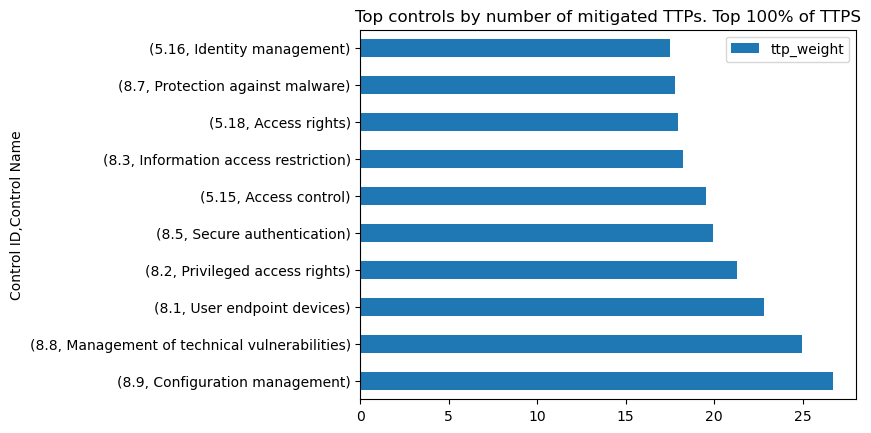

In [80]:
# ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh',title="Number of selected TTPs mitigated per control")

ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()
ttp_control_ranked.sort_values(by='ttp_weight',ascending=False)

# ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. No TTP threshold")
ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. Top {}% of TTPS".format(PERCENTAGE*100))

#### Observations
There are some controls that map to a lot of TTPs. For the complete results for the ‘Government’ sector, there are 215 TTPs and 106 controls. Merging the two gives a resulting set of 2545 mappings. Since there is no measure of control effectiveness to a TTP in this data, they are sorted based on the TTPs they control and their respective weights.

There are two ways to approach the control mapping, either a generic approach or a targeted approach.
- Targeted: Take the most prominent TTPs, those with the highest weights, and display the controls for this. 
- Generic: Take the complete, or near-complete, set of TTPs used by the actors. Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.

When simply counting the number of TTPs that a control covers, only the general ones come to the top. Even if the TTP weights are considered. One possibility to solve this, is to only take the top x% of TTPs into consideration.